In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torchvision.transforms import v2

In [11]:
## Exploratory Data Analysis

# We need to read the data from the csv file
train_df = pd.read_csv('fashion-mnist_train.csv')

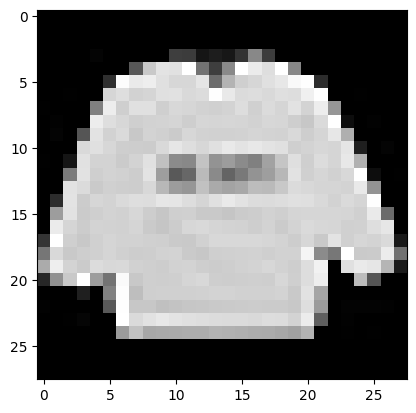

In [12]:
# Plot an example

plt.imshow(train_df.iloc[0,1:].values.reshape(28,28), cmap='gray')
plt.show()

array([[<Axes: title={'center': 'label'}>]], dtype=object)

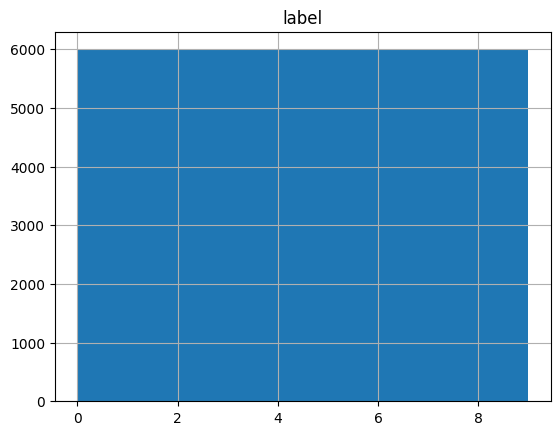

In [13]:
# Check the balance of classes in the data

train_df.hist(column='label')

In [14]:
############
## Data ####
############ 

# Define a custom pytorch dataset
class FMNISTdataset(Dataset):
    def __init__(self, data, transform=None):
        self.images = data.iloc[:, 1:].values.reshape(-1, 28, 28)
        self.labels = data.iloc[:, 0].values
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.uint8)
        if self.transform: 
            image = self.transform(image) 

        return {"image":image, "label":label}
    
class WrapperDataset:
    """
    This class is meant to wrap around the subset after splitting the train and validation sets 
    to allow for different transformations to be applied to each, where train is augmented and validation is not
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image = self.dataset[index]["image"]
        label = self.dataset[index]["label"]
        if self.transform is not None:
            image = self.transform(image)
        return {"image":image,"label": label}

    def __len__(self):
        return len(self.dataset)
    
# Define the transformation for data augmentation
augmentation_transform = nn.Sequential(
    v2.RandomHorizontalFlip(),
    v2.RandomErasing(scale=(0.04, 0.0675))
)
# Additionaly normalize the images to improve model performance
# For this we calculate mean and standard deviation on the dataset images
mean = np.mean(train_df.iloc[:, 1:].values)
std = np.std(train_df.iloc[:, 1:].values)
norm_transform = v2.Normalize(mean=[mean], std=[std])
# The overall transformation that will be applied to the data
transform = nn.Sequential(augmentation_transform,norm_transform)

In [15]:
############
## Model ###
############

# Define the convolutional network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1,16, 3, padding=1)

        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(16,32, 3, padding=1)

        self.flat = nn.Flatten()
        self.fc = nn.LazyLinear(128)
        self.out = nn.Linear(128,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv2(x)
        x = self.flat(x)
        x = self.fc(x)
        x = self.out(x)
        return x

In [16]:
model = ConvNet()
model(torch.tensor(train_df.iloc[0,1:].values.reshape(-1,28,28),dtype=torch.float32).unsqueeze(0))
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'{pytorch_total_params=:_}')

pytorch_total_params=3_217_514


In [17]:
##############################
## K-Folds cross-validation ##
##############################

# Hyper-parameters
k_folds = 5
num_epochs = 10
loss_function = nn.CrossEntropyLoss()
  
# For fold results
results = {}
  
# Prepare dataset
dataset = FMNISTdataset(train_df)
  
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      WrapperDataset(dataset, transform=norm_transform), 
                      batch_size=8, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      WrapperDataset(dataset, transform=norm_transform),
                      batch_size=8, sampler=test_subsampler)
    
    # Init the neural network
    # Giving each fold a fresh instance of the model prevents paramether leakage
    network = ConvNet() 
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        
        # Get images
        images = data['image']
        labels = data['label']

        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = network(images)
        
        # Compute loss
        loss = loss_function(outputs,labels)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
            

    print('Training process has finished. Saving trained model.')

    # Saving the model
    save_path = f'./model-Fold-{fold}-norm.pth'
    torch.save(network.state_dict(), save_path)

    print('Starting testing')

    # Evaluation for this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get images
        images = data['image']
        labels = data['label']

        # Generate outputs
        outputs = network(images)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total +=labels.size(0)
        correct += (predicted ==labels).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)
    
  # Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 0.845
Loss after mini-batch  1000: 0.490


KeyboardInterrupt: 

/tmp/ipykernel_29161/2031740392.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r'model_trained.pth'))


Accuracy: 0.89


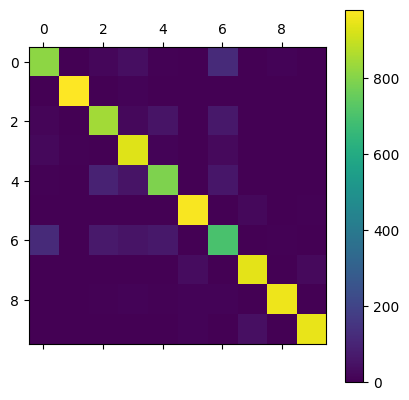

In [18]:
#########
##Test ##
#########
# Read the test file and create the data loader
test_df =pd.read_csv(r'fashion-mnist_test.csv')
testset = FMNISTdataset(test_df)
test_loader = DataLoader(
    WrapperDataset(testset, transform=norm_transform),
    batch_size=8, shuffle=False)

# Test loop
confusion_matrix = np.zeros((10, 10))

# Create an instance of the model and feed it the proper parameters
model = ConvNet()
model.load_state_dict(torch.load(r'model_trained.pth'))
model.eval()
with torch.no_grad():
    for sample in test_loader:
        images = sample["image"]
        labels = sample["label"]
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            confusion_matrix[labels[i], predicted[i]] += 1
# plot the confusion matrix
plt.matshow(confusion_matrix)
plt.colorbar()
#print accuracy
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
#######################
## Single data-split ##
#######################

from torch.utils.data import random_split

train_dataset, validation_dataset = random_split(FMNISTdataset(train_df), [50000, 10000])

train_loader = DataLoader(WrapperDataset(train_dataset, transform=transform), batch_size=8, shuffle=True)

validation_loader = DataLoader(WrapperDataset(validation_dataset, transform=norm_transform), batch_size=8, shuffle=False)

In [ ]:
############
## Train ###
############

# Hyperparameters
lr = 0.001
epochs = 100

# Model instance 
model = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop with the dataloader
for epoch in range(epochs):
    for sample in train_loader:
        images = sample["image"]
        labels = sample["label"]
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [ ]:
#############
## Evaluate #
#############

# Validation loop and construction of the confusion matrix
confusion_matrix = np.zeros((10, 10))
model.eval()
with torch.no_grad():
    for sample in validation_loader:
        images = sample["image"]
        labels = sample["label"]
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            confusion_matrix[labels[i], predicted[i]] += 1
# plot the confusion matrix
plt.matshow(confusion_matrix)
plt.colorbar()
#print accuracy
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
print(f'Accuracy: {accuracy:.2f}')